# Modelling the results Brazilian soccer teams

This notebook uses ~10 years of matches played in the Brazilian soccer first division. We use an online learning algorithm that can rank the teams and give predictions for future games.

We use an algorithm ispired by the ELO score with some adjustements (draws, home advantage, modelling number of goals).

The model is implemented in Tensorflow and data analysis is done using Pandas.

The model can be a starting point for calculating betting odds.

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from scipy.special import binom
import matplotlib.pyplot as plt


# Data loading, processing and analysis

In [2]:
# Load dataset
brasil_csv_url = 'https://www.football-data.co.uk/new/BRA.csv' 
brasil_dataset = pd.read_csv(brasil_csv_url)
brasil_dataset.head()

,Country,League,Season,Date,Time,Home,Away,HG,AG,Res,PH,PD,PA,MaxH,MaxD,MaxA,AvgH,AvgD,AvgA
0,Brazil,Serie A,2012,19/05/2012,22:30,Palmeiras,Portuguesa,1.0,1.0,D,1.75,3.86,5.25,1.76,3.87,5.31,1.69,3.50,4.90
1,Brazil,Serie A,2012,19/05/2012,22:30,Sport Recife,Flamengo RJ,1.0,1.0,D,2.83,3.39,2.68,2.83,3.42,2.70,2.59,3.23,2.58
2,Brazil,Serie A,2012,20/05/2012,01:00,Figueirense,Nautico,2.0,1.0,H,1.60,4.04,6.72,1.67,4.05,7.22,1.59,3.67,5.64
3,Brazil,Serie A,2012,20/05/2012,20:00,Botafogo RJ,Sao Paulo,4.0,2.0,H,2.49,3.35,3.15,2.49,3.39,3.15,2.35,3.26,2.84
4,Brazil,Serie A,2012,20/05/2012,20:00,Corinthians,Fluminense,0.0,1.0,A,1.96,3.53,4.41,1.96,3.53,4.41,1.89,3.33,3.89


In [3]:
# Data cleaning
# Filter any match without result (onne postponed match included in dataset)
brasil_dataset = brasil_dataset[np.any(np.stack([brasil_dataset.Res==i for i in ["A", "D", "H"]]),0)]
# One team has two different spellings
brasil_dataset = brasil_dataset.replace('Athletico-PR','Atletico-PR')


In [4]:
# Creating categorical features/labels
# Results (win Home team, win Away team, draw)
results = {'H': 0, 'A': 2, "D": 1}
results_lookup = tf.lookup.StaticHashTable(tf.lookup.KeyValueTensorInitializer(list(results.keys()), list(results.values())),
    default_value=-1)

# Unique integer per club
clubs = {club: idx for idx, club in enumerate(brasil_dataset.Home.unique())}
clubs_lookup = tf.lookup.StaticHashTable(tf.lookup.KeyValueTensorInitializer(list(clubs.keys()), list(clubs.values())),
    default_value=-1)

# Add these new features
def pre_process(example):
  example['label'] = results_lookup.lookup(example['Res'])
  example['home_club'] = clubs_lookup.lookup(example['Home'])
  example['away_club'] = clubs_lookup.lookup(example['Away'])
  return example

In [5]:
#Dataset creation (note that dataset is ordered by date)

brasil_dataset_dict = dict(brasil_dataset)
full_dataset = tf.data.Dataset.from_tensor_slices(brasil_dataset_dict)
N = brasil_dataset.shape[0]

# 80% train, 20% eval
train_dataset = full_dataset.take(np.round(N*0.8)).map(pre_process)
eval_dataset = full_dataset.skip(np.round(N*0.8)).map(pre_process)

In [57]:
# Some analysis
for examples in train_dataset.batch(N):
  base_rate_train = tf.reduce_mean(tf.one_hot(examples['label'],3),0).numpy()
  max_goals = tf.math.maximum(tf.reduce_max(examples['HG']), tf.reduce_max(examples['AG']))
  avg_H_goals, avg_A_goals = tf.reduce_mean(examples['HG']), tf.reduce_mean(examples['AG'])

print(f"Win/draw/loss ratio (home team): {base_rate_train}")
print(f"Max goals for a team in a single match: {max_goals}")
print(f"Avg goals for a home/away team: {avg_H_goals}/{avg_A_goals}")

Win/draw/loss ratio (home team): [0.49386778 0.26562968 0.24050254]
Max goals for a team in a single match: 6.0
Avg goals for a home/away team: 1.428656895004487/0.9407717618905175


# Modelling (Win/Draw/Loss)

Goal is to predict the probability of home team winning/drawing/losing the match, by knowing just its opponent. After training, we want to have a ranking of best teams and their ratings. We should be able to compute the result's probability from only the ratings of the playing teams (similar to ELO).

**Base Model**

The simplest model could be:

$p(H \text{ beats } A) = σ(s_H-s_A) = p$

and we could train by finding the standings $s=[s_0,s_1,..,s_{K-1}]$ for all K teams by minimizing the binary cross entropy between the predicted probability and the match result represented by the binary label (win/lose) $y$.

$\text{loss}= \sum_i -y_i\log(p_i) - (1-y_i)\log(1-p_i)$

Unfortunately this model does not support draws.

**Binomial draw model**

To model draws, we can approximate a single game as a sequence of many sub-games without draws. If after a even number of sub-games, each player has the same number of wins, we consider it a draw. Now, we define *p* as the probability of winning a sub-game and *q* as the probability of win/draw/lose the game.

$\text{H beats A} => q(H) = \sum_{k=n/2+1}^n\begin{pmatrix}n\\k\end{pmatrix}p^k(1-p)^{n-k}$

$\text{H loses to A} => q(A) = \sum_{k=0}^{n/2-1}\begin{pmatrix}n\\k\end{pmatrix}p^k(1-p)^{n-k}$

$\text{H draws A} => q(D) = \begin{pmatrix}n\\n/2\end{pmatrix}p^{n/2}(1-p)^{n/2}$

Instead of binary cross-entropy, we now use regular cross entropy

$\text{loss}= \sum_i \sum_{j\text{ in }[H,D,A]} -y_i(j)\log(q_i(j)) $

where $y$ is 1 for the key containing the result.

**Model with home advantage**

In our dataset, the home team wins ~2X as often as it loses, so it makes sense to include this in the model in the bias term $b$.

$p(H \text{ beats } A) = σ(s_H-s_A+b) = p$

**Model with scored goals**

TODO

In [7]:
# keras layer to add a bias term (home advantage)
class AddBias(tf.keras.layers.Layer):

  def __init__(self, bias_init, trainable):
      super(AddBias, self).__init__()
      self.bias_init = bias_init
      self.trainable = trainable

  def build(self,input_shapes=1):  
    self.bias = tf.Variable([self.bias_init],
        trainable=self.trainable)
    
  def call(self, inputs):  
      return inputs + self.bias

def get_model(bias_init = 0.0, 
              bias_trainable = True, 
              use_bias = True, 
              n_sub_games = 8):

  home_club = tf.keras.Input(shape=(1))
  away_club = tf.keras.Input(shape=(1))

  # Team standings is stores as an embedding
  club_embedding = tf.keras.layers.Embedding(
      len(clubs),
      1,
      embeddings_initializer='zeros')
  
  # How much better (or worse) is the home team
  logit = club_embedding(home_club) - club_embedding(away_club)
  # Home advantage indepedent of team stading
  if use_bias:
    logit = AddBias(bias_init, bias_trainable)(logit)

  # Sub-game win probability of the home team
  p = tf.nn.sigmoid(logit)

  # Win/draw/loss probability after "n_sub_games"
  q_H = sum([binom(n_sub_games,i)*p**(i)*(1-p)**(n_sub_games-i) for i in range(n_sub_games//2+1,n_sub_games+1)])
  q_A = sum([binom(n_sub_games,i)*p**(i)*(1-p)**(n_sub_games-i) for i in range(0,n_sub_games//2)])
  q_D = binom(n_sub_games,n_sub_games//2)*p**(n_sub_games/2)*(1-p)**(n_sub_games/2)
  
  probs = tf.stack([q_H,q_D,q_A],1)
                  
  model = tf.keras.Model(
      inputs={'home_club': home_club, 'away_club': away_club}, 
      outputs={'logit': logit,'probs': probs})

  return model

def BinomialDrawModel():
  return get_model(use_bias=False)

def BinomialDrawHomeAdvantageModel():
  return get_model()

def ResultLoss(model_output, example):
  one_hot_label = tf.one_hot(example['label'],3)[tf.newaxis,:]
  loss = tf.keras.losses.CategoricalCrossentropy()(
      one_hot_label, 
      model_output['probs'])
  return loss, loss

# Online learning experiments

Our dataset is a ordered (by date) sequence of games. We want to learn the standing of each team and the home advantage over time.

Our model initializes the club standings to 0 and home advantage to 0. We run a single pass over the training set using SGD (stochastic gradient descent) so the model learns the standings and home advantage. There is a trade-off in the choice of learning rate. If the learning rate is too small, the model does not converge/track how teams standings change over time. If learning rate is too fast, each result may impact too much the standings making them noisy.

Then, we evaluate on the remainaing 20% of games. Note that the model is still adapting in the validation set so it can continue to track teams becoming better and worse.

**Metric (cross-entropy)**

Our model is selected as the one with lowest cross-entropy in the validation set.

**Baseline cross-entropy**

To validate that the model is better than no model at all, we need to calculate the cross-entropy of a model without training. We assume that model uses the win/draw/lose rate from the train dataset (80%) and evaluate on the remaining data (20%).



*   Baseline cross-entropy assuming no home advantage

Model always predicts:

$p(D)=0.265$

$p(H)=p(A)=(1-0.265)/2$

no matter the quality of the team.

*   Baseline cross-entropy with home advantage

Model always predicts:

$p(D)=0.265$

$p(H)=0.493$

$p(A)=0.240$


no matter the quality of the team.


In [8]:
def online_learning(dataset, model, learning_rate, loss_fn, return_loss = False):
  # only one pass in the dataset ordered by date, so we can adapt team quality variation
  optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
  all_loss = []
  
  for example in dataset:
      with tf.GradientTape() as tape:
          model_output = model(example)
          train_loss, eval_loss = loss_fn(model_output, example)
          
          if return_loss:
            all_loss.append(eval_loss)

      gradients = tape.gradient(train_loss, model.trainable_weights)
      optimizer.apply_gradients(zip(gradients, model.trainable_weights))

  return all_loss

def online_learning_and_online_evaluation(model, learning_rate, experiment, loss_fn):
  online_learning(train_dataset, model, learning_rate, loss_fn)
  loss_eval = online_learning(eval_dataset, model, learning_rate, loss_fn, True)
  result = {'loss': np.mean(loss_eval),
            'learning_rate':learning_rate, 
            'experiment': experiment,
            'model': model}
  print(result) 
  return result


In [15]:
# Experiment 1: Model with draws based on sub-games
LEARNING_RATES = [0.0025,0.005,0.01,0.02,0.04]
results = []
experiment = 'binomial_draw_model'
for lr in LEARNING_RATES:
  results.append(
      online_learning_and_online_evaluation(BinomialDrawModel(),
                                            lr, 
                                            experiment,
                                            ResultLoss)
      )

{'loss': 1.0724101, 'learning_rate': 0.0025, 'experiment': 'binomial_draw_model', 'model': <keras.engine.functional.Functional object at 0x7fc38fe6bfa0>}
{'loss': 1.0696198, 'learning_rate': 0.005, 'experiment': 'binomial_draw_model', 'model': <keras.engine.functional.Functional object at 0x7fc38fbb7220>}
{'loss': 1.0695162, 'learning_rate': 0.01, 'experiment': 'binomial_draw_model', 'model': <keras.engine.functional.Functional object at 0x7fc38f9bed30>}
{'loss': 1.0716571, 'learning_rate': 0.02, 'experiment': 'binomial_draw_model', 'model': <keras.engine.functional.Functional object at 0x7fc38fb92c10>}
{'loss': 1.0830497, 'learning_rate': 0.04, 'experiment': 'binomial_draw_model', 'model': <keras.engine.functional.Functional object at 0x7fc38f7f00a0>}


In [88]:
# Baseline cross entropy (no home advantage)
for examples in eval_dataset.batch(N):
  base_rate_eval = tf.reduce_mean(tf.one_hot(examples['label'],3),0).numpy()

base_rate_no_home_advantage = np.array([(1-base_rate_train[1])/2, base_rate_train[1], (1-base_rate_train[1])/2])
baseline_cross_entropy = np.sum(-base_rate_eval*np.log(base_rate_no_home_advantage))

print(f"Win/draw/loss ratio (home team) for validation: {base_rate_eval}")
print(f"Win/draw/loss ratio (home team) prediction based on train base rate: {base_rate_no_home_advantage}")
print(f"Baseline cross-entropy assuming no home advantage: {baseline_cross_entropy}")

Win/draw/loss ratio (home team) for validation: [0.4557416  0.28947368 0.2547847 ]
Win/draw/loss ratio (home team) prediction based on train base rate: [0.36718516 0.26562968 0.36718516]
Baseline cross-entropy assuming no home advantage: 1.095609927825924


Text(0, 0.5, 'Relative cross-entropy [%]')

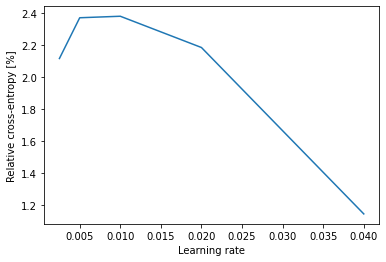

In [30]:
# Result
filtered_results = [r for r in results if r['experiment']=='binomial_draw_model'] 
lr = [r['learning_rate'] for r in filtered_results]
relative_cross_entropy = [(1-r['loss']/baseline_cross_entropy)*100 for r in filtered_results]

plt.plot(lr, relative_cross_entropy)
plt.xlabel('Learning rate')
plt.ylabel('Relative cross-entropy [%]')

In [27]:
# Experiment 2: Model with draws based on sub-games and home advantage
experiment = 'binomial_draw_home_advantage_model'
for lr in LEARNING_RATES:
  results.append(
      online_learning_and_online_evaluation(BinomialDrawHomeAdvantageModel(),
                                            lr, 
                                            experiment,
                                            ResultLoss)
      )

/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:638: UserWarning: Input dict contained keys ['Country', 'League', 'Season', 'Date', 'Time', 'Home', 'Away', 'HG', 'AG', 'Res', 'PH', 'PD', 'PA', 'MaxH', 'MaxD', 'MaxA', 'AvgH', 'AvgD', 'AvgA', 'label'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


{'loss': 1.0443347, 'learning_rate': 0.0025, 'experiment': 'binomial_draw_home_advantage_model', 'model': <keras.engine.functional.Functional object at 0x7fc3a286c3a0>}
{'loss': 1.0411006, 'learning_rate': 0.005, 'experiment': 'binomial_draw_home_advantage_model', 'model': <keras.engine.functional.Functional object at 0x7fc38fd9cb50>}
{'loss': 1.0404531, 'learning_rate': 0.01, 'experiment': 'binomial_draw_home_advantage_model', 'model': <keras.engine.functional.Functional object at 0x7fc38fd9fa90>}
{'loss': 1.043601, 'learning_rate': 0.02, 'experiment': 'binomial_draw_home_advantage_model', 'model': <keras.engine.functional.Functional object at 0x7fc38fd82a30>}
{'loss': 1.061619, 'learning_rate': 0.04, 'experiment': 'binomial_draw_home_advantage_model', 'model': <keras.engine.functional.Functional object at 0x7fc38fa93af0>}


In [89]:
# Baseline cross entropy (with home advantage)
baseline_cross_entropy_with_home_advantage = np.sum(-base_rate_eval*np.log(base_rate_train))

print(f"Win/draw/loss ratio (home team) for validation: {base_rate_eval}")
print(f"Win/draw/loss ratio (home team) prediction based on train base rate: {base_rate_train}")
print(f"Cross-entropy assuming no home advantage: {baseline_cross_entropy_with_home_advantage}")

Win/draw/loss ratio (home team) for validation: [0.4557416  0.28947368 0.2547847 ]
Win/draw/loss ratio (home team) prediction based on train base rate: [0.49386778 0.26562968 0.24050254]
Cross-entropy assuming no home advantage: 1.068335771560669


Text(0, 0.5, 'Relative cross-entropy [%]')

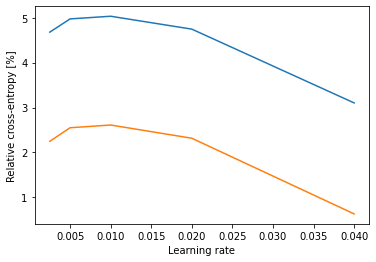

In [31]:
# Result
filtered_results = [r for r in results if r['experiment']=='binomial_draw_home_advantage_model'] 
lr = [r['learning_rate'] for r in filtered_results]
relative_cross_entropy = [(1-r['loss']/baseline_cross_entropy)*100 for r in filtered_results]
relative_cross_entropy_h_a = [(1-r['loss']/baseline_cross_entropy_with_home_advantage)*100 for r in filtered_results]


plt.plot(lr, relative_cross_entropy)
plt.plot(lr, relative_cross_entropy_h_a)

plt.xlabel('Learning rate')
plt.ylabel('Relative cross-entropy [%]')

# Modelling (Goals, not results)

Difference: predict goal difference. From PMF (probability mass function of goal difference distribution, we can infer win/draw/loss distribution).

Absolute goals: predict home and away goals. With the PMF we can infer, difference PMF and win/draw/loss PMF.

The advantage of modelling goals instead of results is that better teams not only will win more frequently, but also have higher average goal difference. We can use this signal to better learn each team standing.


**Binomial model of goals scored**
We assume each team has $n$ tries to score, and the probability of home team scoring in a given try (sub-game) is:

$p(H \text{ scores } A) = σ(s_H-s_A+b_H) = p_H$

and

$p(A \text{ scores } H) = σ(-(s_H-s_A)+b_A) = p_A$

thus, the probability of home team scoring $k$ goals is:

$q_H(k)=\begin{pmatrix}n\\k\end{pmatrix}p_H^{k}(1-p_H)^{n-k}$

snd similarly for away team.

**Laplace model of goals scores**

This is a more flexible distribution, where the higher the difference of standings, the higher the number os scored goals (also the higher the home advantage is). Also, we can control the variance ($\alpha$) of the distribution.

$q_H(k) = \exp(-(s_H-s_A+b_H)*\alpha_H)/\sum_kq_H(k)$

Softmax normalization is used to ensure distribution is a PMF.

**Goals vs goal-difference**

Both approaches can work and both are trained with cross-entropy.

With goal difference the loss is the cross-entropy between the ground truth goal difference and the goal difference PMF output of the model. For example:

$p(\text{diff}=1) = \sum_{k=1}^{6}q_H(k)q_A(k-1) $

and probability of winning:

$p(\text{win}) = \sum_{k=1}^{k_{max}}p(\text{diff}=k)$

When modelling the absolute number of goals, the loss is the cross-entropy of ground truth home goals and the predicted home goals PMF added to the cross-entropy of ground truth away goals and the predicted away goals PMF.



In [67]:
class Scale(tf.keras.layers.Layer):
  # Multiplies input by a variable
  def __init__(self, scale_init, trainable=True):
      super(Scale, self).__init__()
      self.scale_init = scale_init
      self.trainable = trainable

  def build(self,input_shapes=1):  
    self.scale = tf.Variable([self.scale_init],
        trainable=self.trainable)
    
  def call(self, inputs):  
      return inputs * self.scale

def goal_binomial(logit, n_sub_games):
  p = tf.nn.sigmoid(logit)
  probs_list = [binom(n_sub_games,i)*p**(i)*(1-p)**(n_sub_games-i) for i in range(n_sub_games+1)] 
  return tf.stack(probs_list,1)

def goal_laplace(logit, n_sub_games):
  scale=Scale(scale_init=0.5)
  categorical_logit = scale(
      -tf.math.abs(
          logit - tf.cast(tf.linspace(0,n_sub_games,n_sub_games+1), tf.float32)
          )
      )  
  return tf.nn.softmax(categorical_logit)


def get_model_goals(n_sub_games,
                    bias_init = [0.0,0.0], 
                    bias_trainable = True,
                    goal_distribution = 'binomial' 
                    ):

  home_club = tf.keras.Input(shape=(1))
  away_club = tf.keras.Input(shape=(1))

  # Team standings is stores as an embedding
  club_embedding = tf.keras.layers.Embedding(
      len(clubs),
      1,
      embeddings_initializer='zeros')
  
  # How much better (or worse) is the home team
  logit = club_embedding(home_club) - club_embedding(away_club)
  
  bias_init = tf.cast(bias_init, tf.float32)
  # Logit home team score in a sub-game
  logit_home = AddBias(bias_init[0], bias_trainable)(logit)
  # Logit away team score in a sub-game
  logit_away = AddBias(bias_init[1], bias_trainable)(-logit)

  if goal_distribution == 'binomial':
    goal_distribution_fn = goal_binomial
  if goal_distribution == 'laplace':
    goal_distribution_fn = goal_laplace
  
  # Categorical variable for goals scored by home team
  probs_home = goal_distribution_fn(logit_home, n_sub_games)

  # Categorical variable for goals scored by away team
  probs_away = goal_distribution_fn(logit_away, n_sub_games)

  # Matrix with all possible score probabilities
  scores = tf.matmul(tf.reshape(probs_home,[-1,n_sub_games+1,1]),
                     tf.reshape(probs_away,[-1,1,n_sub_games+1]))
  
  # Categorical variable with score difference, for n_sub_games = 2 => [-2,-1,0,1,2]
  probs_list = [tf.reduce_sum(tf.linalg.diag_part(scores,0,-i),keepdims=True) for i in range(-n_sub_games,n_sub_games+1)]
  probs_goal_diff = tf.stack(probs_list, 1)

  
  # Win/draw/loss probability (goal difference positive/zero/negative)
  probs_HDA = tf.stack([sum(probs_list[n_sub_games+1:]),
                       probs_list[n_sub_games],
                       sum(probs_list[:n_sub_games])], 1)
                  
  model = tf.keras.Model(
      inputs={'home_club': home_club, 'away_club': away_club}, 
      outputs={'probs_home': probs_home,'probs_away':probs_away,'probs_goal_diff': probs_goal_diff, 'probs': probs_HDA})

  return model


def GoalDifferenceLoss(model_output, example, n_sub_games):
  # Categorical 0 to 2*n_sub_games+1 (inclusive)
  goal_difference = tf.cast(
      example['HG']-example['AG'] + n_sub_games,
      tf.int32)
  one_hot_label = tf.one_hot(goal_difference, 2*n_sub_games + 1)[tf.newaxis,:]
  # Train loss on goal difference
  loss = tf.keras.losses.CategoricalCrossentropy()(
      one_hot_label, 
      model_output['probs_goal_diff'])
  
  # Eval loss on win/draw/loss prediction
  eval_loss = ResultLoss(model_output, example)
  return loss, eval_loss

def GoalLoss(model_output, example, n_sub_games):
  # Categorical 0 to n_sub_games+1 (inclusive)
  goals_home = tf.cast(example['HG'], tf.int32)
  goals_away = tf.cast(example['AG'], tf.int32)
  one_hot_label_H = tf.one_hot(goals_home, n_sub_games + 1)
  one_hot_label_A = tf.one_hot(goals_away, n_sub_games + 1)
  # Train loss on goals
  loss = 0.5 * (tf.keras.losses.CategoricalCrossentropy()(
      one_hot_label_H, 
      model_output['probs_home']) +
      tf.keras.losses.CategoricalCrossentropy()(
      one_hot_label_A, 
      model_output['probs_away']))
  
  # Eval loss on win/draw/loss prediction
  eval_loss = ResultLoss(model_output, example)
  return loss, eval_loss

def BinomialGoalDifferenceModelAndLoss(n_sub_games = 6):
  # make sure model and loss use the same n_sub_games
  loss_fn = lambda x, y: GoalDifferenceLoss(x, y, n_sub_games)
  model_fn = get_model_goals(n_sub_games, goal_distribution='binomial') 
  return model_fn, loss_fn

def LaplaceGoalDifferenceModelAndLoss(n_sub_games = 6):
  # make sure model and loss use the same n_sub_games
  model_fn = get_model_goals(
      n_sub_games, 
      bias_init=[avg_H_goals, avg_A_goals], 
      goal_distribution='laplace')
  loss_fn = lambda x, y: GoalDifferenceLoss(x, y, n_sub_games) 
  return model_fn, loss_fn

def LaplaceGoalModelAndLoss(n_sub_games = 6):
  # make sure model and loss use the same n_sub_games
  model_fn = get_model_goals(
      n_sub_games, 
      bias_init=[avg_H_goals, avg_A_goals], 
      goal_distribution='laplace')
  loss_fn = lambda x, y: GoalLoss(x, y, n_sub_games) 
  return model_fn, loss_fn

# Experiments

For modelling absolute goals, we initialize the bias of the laplace distribution to be the average number of goals scored at home/away in the training set to increase convergenece speed.

In [ ]:
# Experiment 3: Model that predicts goal difference with binomial distribution and home advantage
LEARNING_RATES = [0.0025,0.005,0.01,0.02,0.04]
results = []
experiment = 'binomial_goal_difference_model'
for lr in LEARNING_RATES:
  model_fn, loss_fn = BinomialGoalDifferenceModelAndLoss()
  results.append(online_learning_and_online_evaluation(model_fn,
                                      lr, 
                                      experiment,
                                      loss_fn))
  

In [70]:
# Experiment 4: Model that predicts goal difference with laplace distribution and home advantage
experiment = 'laplace_goal_difference_model'
for lr in LEARNING_RATES:
  model_fn, loss_fn = LaplaceGoalDifferenceModelAndLoss()
  results.append(online_learning_and_online_evaluation(model_fn,
                                      lr, 
                                      experiment,
                                      loss_fn))

{'loss': 1.0422505, 'learning_rate': 0.0025, 'experiment': 'laplace_goal_difference_model', 'model': <keras.engine.functional.Functional object at 0x7f831b87fe20>}
{'loss': 1.0368804, 'learning_rate': 0.005, 'experiment': 'laplace_goal_difference_model', 'model': <keras.engine.functional.Functional object at 0x7f832b297790>}
{'loss': 1.0377587, 'learning_rate': 0.01, 'experiment': 'laplace_goal_difference_model', 'model': <keras.engine.functional.Functional object at 0x7f832a9f9490>}
{'loss': 1.0392169, 'learning_rate': 0.02, 'experiment': 'laplace_goal_difference_model', 'model': <keras.engine.functional.Functional object at 0x7f831bd2df40>}
{'loss': 1.0445349, 'learning_rate': 0.04, 'experiment': 'laplace_goal_difference_model', 'model': <keras.engine.functional.Functional object at 0x7f831b7405e0>}


In [71]:
# Experiment 5: Model that predicts scored goals with laplace distribution and home advantage
experiment = 'laplace_goal_model'
for lr in LEARNING_RATES:
  model_fn, loss_fn = LaplaceGoalModelAndLoss()
  results.append(online_learning_and_online_evaluation(model_fn,
                                      lr, 
                                      experiment,
                                      loss_fn))

{'loss': 1.0545274, 'learning_rate': 0.0025, 'experiment': 'laplace_goal_model', 'model': <keras.engine.functional.Functional object at 0x7f831bd98c10>}
{'loss': 1.0466746, 'learning_rate': 0.005, 'experiment': 'laplace_goal_model', 'model': <keras.engine.functional.Functional object at 0x7f831ba6e850>}
{'loss': 1.0402821, 'learning_rate': 0.01, 'experiment': 'laplace_goal_model', 'model': <keras.engine.functional.Functional object at 0x7f831bd7d6d0>}
{'loss': 1.0361018, 'learning_rate': 0.02, 'experiment': 'laplace_goal_model', 'model': <keras.engine.functional.Functional object at 0x7f831bf6a370>}
{'loss': 1.038636, 'learning_rate': 0.04, 'experiment': 'laplace_goal_model', 'model': <keras.engine.functional.Functional object at 0x7f831b069700>}


Text(0, 0.5, 'Relative cross-entropy [%]')

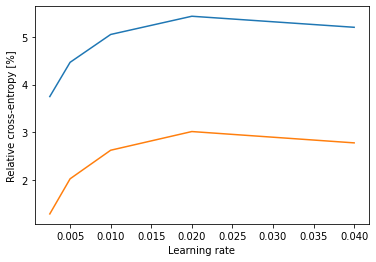

In [90]:
# Result
filtered_results = [r for r in results if r['experiment']=='laplace_goal_model'] 
lr = [r['learning_rate'] for r in filtered_results]
relative_cross_entropy = [(1-r['loss']/baseline_cross_entropy)*100 for r in filtered_results]
relative_cross_entropy_h_a = [(1-r['loss']/baseline_cross_entropy_with_home_advantage)*100 for r in filtered_results]


plt.plot(lr, relative_cross_entropy)
plt.plot(lr, relative_cross_entropy_h_a)

plt.xlabel('Learning rate')
plt.ylabel('Relative cross-entropy [%]')

In [79]:
# Taking the best model and ranking teams according to scores
best_model = [r['model'] for r in results if r['learning_rate']==0.02 and r['experiment'] == 'laplace_goal_model'][0]
club_scores = {'club': [], 'score': []}
for club, idx in clubs.items():
  club_scores['club'].append(club)
  club_scores['score'].append(best_model.trainable_weights[0][idx,0].numpy())
pd.DataFrame(club_scores).sort_values('score', ascending=False,ignore_index=True)[:10]

,club,score
0,Palmeiras,0.465485
1,Atletico-MG,0.399660
2,Flamengo RJ,0.372157
3,Internacional,0.312990
4,Gremio,0.235316
5,Fluminense,0.222988
6,Corinthians,0.174411
7,Fortaleza,0.159197
8,Sao Paulo,0.145478
9,Santos,0.112192


In [ ]:
https://footballdatabase.com/ranking/brazil/1

Best clubs in Brazil (Feb-2023) for comparison according to:

https://footballdatabase.com/ranking/brazil/1

\begin{array}{cc}
Palmeiras&1808\\
Flamengo&1747\\
Internacional&1745\\
Fluminense&1712\\
Atletico-MG&1693\\
Atletico-PR&1639\\
Corinthians&1631\\
Sao Paulo&1627\\
America-MG&1606\\
Gremio&1599\\
\end{array}

In [86]:
# Best team playing at home vs 10-th ranked
model_output = best_model({'home_club': clubs['Palmeiras'], 'away_club': clubs['Santos']})
print(f"Home win/draw/lose probability: {tf.squeeze(model_output['probs'])}")
print(f"Home goals probability (0 to 6 goals): {tf.squeeze(model_output['probs_home'])}")


Home win/draw/lose probability: [0.61814433 0.21954955 0.16230619]
Home goals probability: [0.14550768 0.3267527  0.29794723 0.1326802  0.05908439 0.02631112
 0.01171672]


# Analysis and next steps

We showed how to estimate team strengths/standings in the Brazilian soccer league by observing ~10 years of played games.

The model used is an online model that can adapt to teams getting better and worse overtime. The result of the model is that for any given game, it can predict the number of goals per team as well as win/draw lose probability better than chance.

As a baseline for comparing the performance of our model, we had 2 baseline performances we wanted to beat:

Baseline 1: a blind model that does not know who is playing and who is the home/away team. The model only knows the base win/draw/lose ratios in the training dataset.

Baseline 2: a blind model that does not know who is playing, but knows the home advantage information. The model only knows the home team win/draw/lose ratios in the training dataset.

Our final model betas the first baseline by ~5%  and the second baseline by ~3% in terms of cross-entropy of the prediction of the match result. We further validated the model, by comparing its club ranking with rankings found on the internet (they match well).

The main features used in the model are the knowledge of who is the home team and which teams are playing. The team standings adjusted by home advantage are found by trying to predict how many goals they have scored in past matches using a discrete laplace distrbution of goals scored.

To improve the model, we can:

- Use more data (continental matches, cups and regional matches)
- Separate team strength by offence/defense (2 embeddings instead of 1)
- Use more features (xG, number of injured/suspended players...)

To better evaluate the model, we can:
- Use it for betting purposes, comparing to live odds...